In [1]:
# 1. Imports and Configuration
# -------------------------------
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torchvision.transforms as T
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision.models.segmentation import deeplabv3_resnet50
from sklearn.model_selection import train_test_split
from PIL import Image
from glob import glob
from tqdm import tqdm
from collections import Counter

import albumentations as A
from albumentations.pytorch import ToTensorV2

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
# Config
NUM_CLASSES = 12
IMAGE_SIZE = (512, 512)
BATCH_SIZE = 8 
EPOCHS = 25
PATIENCE = 5
LEARNING_RATE = 2e-4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# 2. Class Mappings
# -------------------------------
rgb_to_class = {
    (0, 255, 255): 0, (255, 255, 0): 1, (255, 0, 255): 2,
    (0, 255, 0): 3, (0, 0, 255): 4, (255, 255, 255): 5,
    (0, 0, 0): 6, (60, 16, 152): 7, (132, 41, 246): 8,
    (110, 193, 228): 9, (254, 221, 58): 10, (155, 155, 155): 11
}
class_to_rgb = {v: k for k, v in rgb_to_class.items()}


def rgb_mask_to_class(mask):
    mask = np.array(mask)
    class_mask = np.zeros(mask.shape[:2], dtype=np.uint8)
    for rgb, idx in rgb_to_class.items():
        class_mask[(mask == rgb).all(axis=-1)] = idx
    return class_mask

In [4]:
# 3. Dataset Setup
# -------------------------------
deepglobe_dir = "/kaggle/input/deepglobe-land-cover-classification-dataset/train"
dubai_dir = "/kaggle/input/semantic-segmentation-of-aerial-imagery/Semantic segmentation dataset"

deepglobe_images = sorted(glob(os.path.join(deepglobe_dir, "*.jpg")))
deepglobe_masks = sorted(glob(os.path.join(deepglobe_dir, "*.png")))

dubai_images, dubai_masks = [], []
for tile in sorted(os.listdir(dubai_dir)):
    tile_path = os.path.join(dubai_dir, tile)
    if os.path.isdir(tile_path):
        dubai_images.extend(sorted(glob(os.path.join(tile_path, "images", '*.jpg'))))
        dubai_masks.extend(sorted(glob(os.path.join(tile_path, "masks", '*.png'))))

all_images = deepglobe_images + dubai_images
all_masks = deepglobe_masks + dubai_masks
sources = ['deepglobe'] * len(deepglobe_images) + ['dubai'] * len(dubai_images)

train_imgs, val_imgs, train_masks, val_masks, train_src, val_src = train_test_split(
    all_images, all_masks, sources, test_size=0.2, stratify=sources, random_state=42
)

In [5]:
# 4. Dataset Class and Augmentation
# -------------------------------
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = np.array(Image.open(self.image_paths[idx]).convert('RGB'))
        mask = Image.open(self.mask_paths[idx]).convert('RGB')
        mask = rgb_mask_to_class(mask)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']

        return img.float(), mask.long()


train_transform = A.Compose([
    A.Resize(*IMAGE_SIZE),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(*IMAGE_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


train_dataset = SegmentationDataset(train_imgs, train_masks, transform=train_transform)
val_dataset = SegmentationDataset(val_imgs, val_masks, transform=val_transform)

weights = [1.0 / Counter(train_src)[src] for src in train_src]
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          sampler=WeightedRandomSampler(weights, len(weights), replacement=True))
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)



In [6]:
#model
model = deeplabv3_resnet50(pretrained=False, num_classes=NUM_CLASSES).to(DEVICE)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 197MB/s]


In [7]:
# 6. Loss, Metrics, Training Loop
# -------------------------------
class DiceLoss(nn.Module):
    def forward(self, preds, targets):
        preds = torch.softmax(preds, dim=1)
        targets_one_hot = torch.nn.functional.one_hot(targets, NUM_CLASSES).permute(0, 3, 1, 2).float()
        intersection = (preds * targets_one_hot).sum(dim=(2, 3))
        union = preds.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))
        dice = (2. * intersection + 1e-6) / (union + 1e-6)
        return 1 - dice.mean()


class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma

    def forward(self, preds, targets):
        logpt = -torch.nn.functional.cross_entropy(preds, targets, reduction='none')
        pt = torch.exp(logpt)
        return (-((1 - pt) ** self.gamma) * logpt).mean()


class CombinedLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.dice = DiceLoss()
        self.focal = FocalLoss()

    def forward(self, preds, targets):
        return self.dice(preds, targets) + self.focal(preds, targets)


def compute_metrics(preds, targets):
    preds = torch.argmax(preds, dim=1).detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()
    ious, dices = [], []
    correct = (preds == targets).sum()
    total = np.prod(targets.shape)

    for cls in range(NUM_CLASSES):
        p = (preds == cls)
        t = (targets == cls)
        intersection = (p & t).sum()
        union = (p | t).sum()
        if union > 0:
            ious.append(intersection / union)
        dice = (2 * intersection) / (p.sum() + t.sum() + 1e-6)
        dices.append(dice)

    return {
        "Pixel Accuracy": correct / total,
        "Mean IoU": np.nanmean(ious),
        "Mean Dice": np.nanmean(dices),
        "Mean F1": np.nanmean(dices)
    }


def train(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for imgs, masks in tqdm(loader, desc="Training"):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        optimizer.zero_grad()
        out = model(imgs)
        if isinstance(out, dict): out = out["out"]
        out = torch.nn.functional.interpolate(out, size=masks.shape[1:], mode='bilinear', align_corners=False)
        loss = loss_fn(out, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


def validate(model, loader, loss_fn):
    model.eval()
    total_loss = 0
    all_metrics = {"Pixel Accuracy": [], "Mean IoU": [], "Mean Dice": [], "Mean F1": []}
    with torch.no_grad():
        for imgs, masks in tqdm(loader, desc="Validation"):
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            out = model(imgs)
            if isinstance(out, dict): out = out["out"]
            out = torch.nn.functional.interpolate(out, size=masks.shape[1:], mode='bilinear', align_corners=False)
            loss = loss_fn(out, masks)
            total_loss += loss.item()
            metrics = compute_metrics(out, masks)
            for k in all_metrics:
                all_metrics[k].append(metrics[k])
    avg_metrics = {k: np.mean(v) for k, v in all_metrics.items()}
    return total_loss / len(loader), avg_metrics


In [8]:
# 7. Training Loop
# -------------------------------
loss_fn = CombinedLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5, verbose=True)

best_miou = 0
patience_counter = 0

for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    train_loss = train(model, train_loader, optimizer, loss_fn)
    val_loss, val_metrics = validate(model, val_loader, loss_fn)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    for k, v in val_metrics.items():
        print(f"{k}: {v:.4f}")

    scheduler.step(val_loss)

    if val_metrics["Mean IoU"] > best_miou:
        best_miou = val_metrics["Mean IoU"]
        torch.save(model.state_dict(), "best_model.pth")
        print(" Best model saved!")
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= PATIENCE:
        print(" Early stopping triggered.")
        break

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/25


Validation: 100%|██████████| 22/22 [06:12<00:00, 16.92s/it]


Train Loss: 1.7163 | Val Loss: 1.4352
Pixel Accuracy: 0.7483
Mean IoU: 0.2915
Mean Dice: 0.2685
Mean F1: 0.2685
 Best model saved!

Epoch 2/25


Validation: 100%|██████████| 22/22 [06:01<00:00, 16.44s/it]


Train Loss: 1.3641 | Val Loss: 1.3892
Pixel Accuracy: 0.7447
Mean IoU: 0.2839
Mean Dice: 0.2849
Mean F1: 0.2849

Epoch 3/25


Validation: 100%|██████████| 22/22 [06:02<00:00, 16.49s/it]


Train Loss: 1.2865 | Val Loss: 1.1987
Pixel Accuracy: 0.7984
Mean IoU: 0.3983
Mean Dice: 0.3566
Mean F1: 0.3566
 Best model saved!

Epoch 4/25


Validation: 100%|██████████| 22/22 [06:02<00:00, 16.49s/it]


Train Loss: 1.2360 | Val Loss: 1.2491
Pixel Accuracy: 0.7887
Mean IoU: 0.3664
Mean Dice: 0.3292
Mean F1: 0.3292

Epoch 5/25


Validation: 100%|██████████| 22/22 [06:04<00:00, 16.58s/it]


Train Loss: 1.1721 | Val Loss: 1.1482
Pixel Accuracy: 0.8151
Mean IoU: 0.4209
Mean Dice: 0.3786
Mean F1: 0.3786
 Best model saved!

Epoch 6/25


Validation: 100%|██████████| 22/22 [06:07<00:00, 16.73s/it]


Train Loss: 1.1319 | Val Loss: 1.1737
Pixel Accuracy: 0.8030
Mean IoU: 0.3932
Mean Dice: 0.3630
Mean F1: 0.3630

Epoch 7/25


Validation: 100%|██████████| 22/22 [06:01<00:00, 16.42s/it]


Train Loss: 1.0992 | Val Loss: 1.2123
Pixel Accuracy: 0.7970
Mean IoU: 0.3808
Mean Dice: 0.3569
Mean F1: 0.3569

Epoch 8/25


Validation: 100%|██████████| 22/22 [06:02<00:00, 16.48s/it]


Train Loss: 1.1790 | Val Loss: 1.1631
Pixel Accuracy: 0.8172
Mean IoU: 0.4170
Mean Dice: 0.3798
Mean F1: 0.3798

Epoch 9/25


Validation: 100%|██████████| 22/22 [06:00<00:00, 16.40s/it]


Train Loss: 1.0400 | Val Loss: 1.0960
Pixel Accuracy: 0.8317
Mean IoU: 0.4547
Mean Dice: 0.4061
Mean F1: 0.4061
 Best model saved!

Epoch 10/25


Validation: 100%|██████████| 22/22 [06:03<00:00, 16.51s/it]


Train Loss: 1.0414 | Val Loss: 1.0896
Pixel Accuracy: 0.8359
Mean IoU: 0.4503
Mean Dice: 0.4079
Mean F1: 0.4079

Epoch 11/25


Validation: 100%|██████████| 22/22 [06:04<00:00, 16.57s/it]


Train Loss: 1.0113 | Val Loss: 1.1059
Pixel Accuracy: 0.8363
Mean IoU: 0.4546
Mean Dice: 0.3992
Mean F1: 0.3992

Epoch 12/25


Validation: 100%|██████████| 22/22 [06:00<00:00, 16.37s/it]


Train Loss: 1.0010 | Val Loss: 1.0729
Pixel Accuracy: 0.8402
Mean IoU: 0.4702
Mean Dice: 0.4194
Mean F1: 0.4194
 Best model saved!

Epoch 13/25


Validation: 100%|██████████| 22/22 [06:00<00:00, 16.40s/it]


Train Loss: 0.9917 | Val Loss: 1.0660
Pixel Accuracy: 0.8470
Mean IoU: 0.4763
Mean Dice: 0.4171
Mean F1: 0.4171
 Best model saved!

Epoch 14/25


Validation: 100%|██████████| 22/22 [06:09<00:00, 16.79s/it]


Train Loss: 0.9649 | Val Loss: 1.0609
Pixel Accuracy: 0.8448
Mean IoU: 0.4796
Mean Dice: 0.4294
Mean F1: 0.4294
 Best model saved!

Epoch 15/25


Validation: 100%|██████████| 22/22 [06:01<00:00, 16.43s/it]


Train Loss: 0.9696 | Val Loss: 1.0743
Pixel Accuracy: 0.8415
Mean IoU: 0.4720
Mean Dice: 0.4182
Mean F1: 0.4182

Epoch 16/25


Validation: 100%|██████████| 22/22 [06:04<00:00, 16.57s/it]


Train Loss: 0.9489 | Val Loss: 1.0509
Pixel Accuracy: 0.8573
Mean IoU: 0.4753
Mean Dice: 0.4177
Mean F1: 0.4177

Epoch 17/25


Validation: 100%|██████████| 22/22 [06:03<00:00, 16.54s/it]


Train Loss: 0.9669 | Val Loss: 1.0477
Pixel Accuracy: 0.8441
Mean IoU: 0.4933
Mean Dice: 0.4333
Mean F1: 0.4333
 Best model saved!

Epoch 18/25


Validation: 100%|██████████| 22/22 [06:01<00:00, 16.42s/it]


Train Loss: 0.9378 | Val Loss: 1.0583
Pixel Accuracy: 0.8422
Mean IoU: 0.4946
Mean Dice: 0.4306
Mean F1: 0.4306
 Best model saved!

Epoch 19/25


Validation: 100%|██████████| 22/22 [06:02<00:00, 16.47s/it]


Train Loss: 0.9695 | Val Loss: 1.1029
Pixel Accuracy: 0.8367
Mean IoU: 0.4769
Mean Dice: 0.4236
Mean F1: 0.4236

Epoch 20/25


Validation: 100%|██████████| 22/22 [06:02<00:00, 16.50s/it]


Train Loss: 0.9426 | Val Loss: 1.0693
Pixel Accuracy: 0.8435
Mean IoU: 0.4900
Mean Dice: 0.4316
Mean F1: 0.4316

Epoch 21/25


Validation: 100%|██████████| 22/22 [06:01<00:00, 16.42s/it]


Train Loss: 0.9222 | Val Loss: 1.0336
Pixel Accuracy: 0.8560
Mean IoU: 0.4950
Mean Dice: 0.4387
Mean F1: 0.4387
 Best model saved!

Epoch 22/25


Validation: 100%|██████████| 22/22 [06:05<00:00, 16.63s/it]


Train Loss: 0.9210 | Val Loss: 1.0420
Pixel Accuracy: 0.8559
Mean IoU: 0.4916
Mean Dice: 0.4340
Mean F1: 0.4340

Epoch 23/25


Validation: 100%|██████████| 22/22 [06:02<00:00, 16.48s/it]


Train Loss: 0.9186 | Val Loss: 1.0299
Pixel Accuracy: 0.8660
Mean IoU: 0.4951
Mean Dice: 0.4397
Mean F1: 0.4397
 Best model saved!

Epoch 24/25


Validation: 100%|██████████| 22/22 [06:02<00:00, 16.48s/it]


Train Loss: 0.9078 | Val Loss: 1.0440
Pixel Accuracy: 0.8539
Mean IoU: 0.5014
Mean Dice: 0.4400
Mean F1: 0.4400
 Best model saved!

Epoch 25/25


Validation: 100%|██████████| 22/22 [06:01<00:00, 16.42s/it]


Train Loss: 0.8907 | Val Loss: 1.0345
Pixel Accuracy: 0.8554
Mean IoU: 0.5035
Mean Dice: 0.4421
Mean F1: 0.4421
 Best model saved!


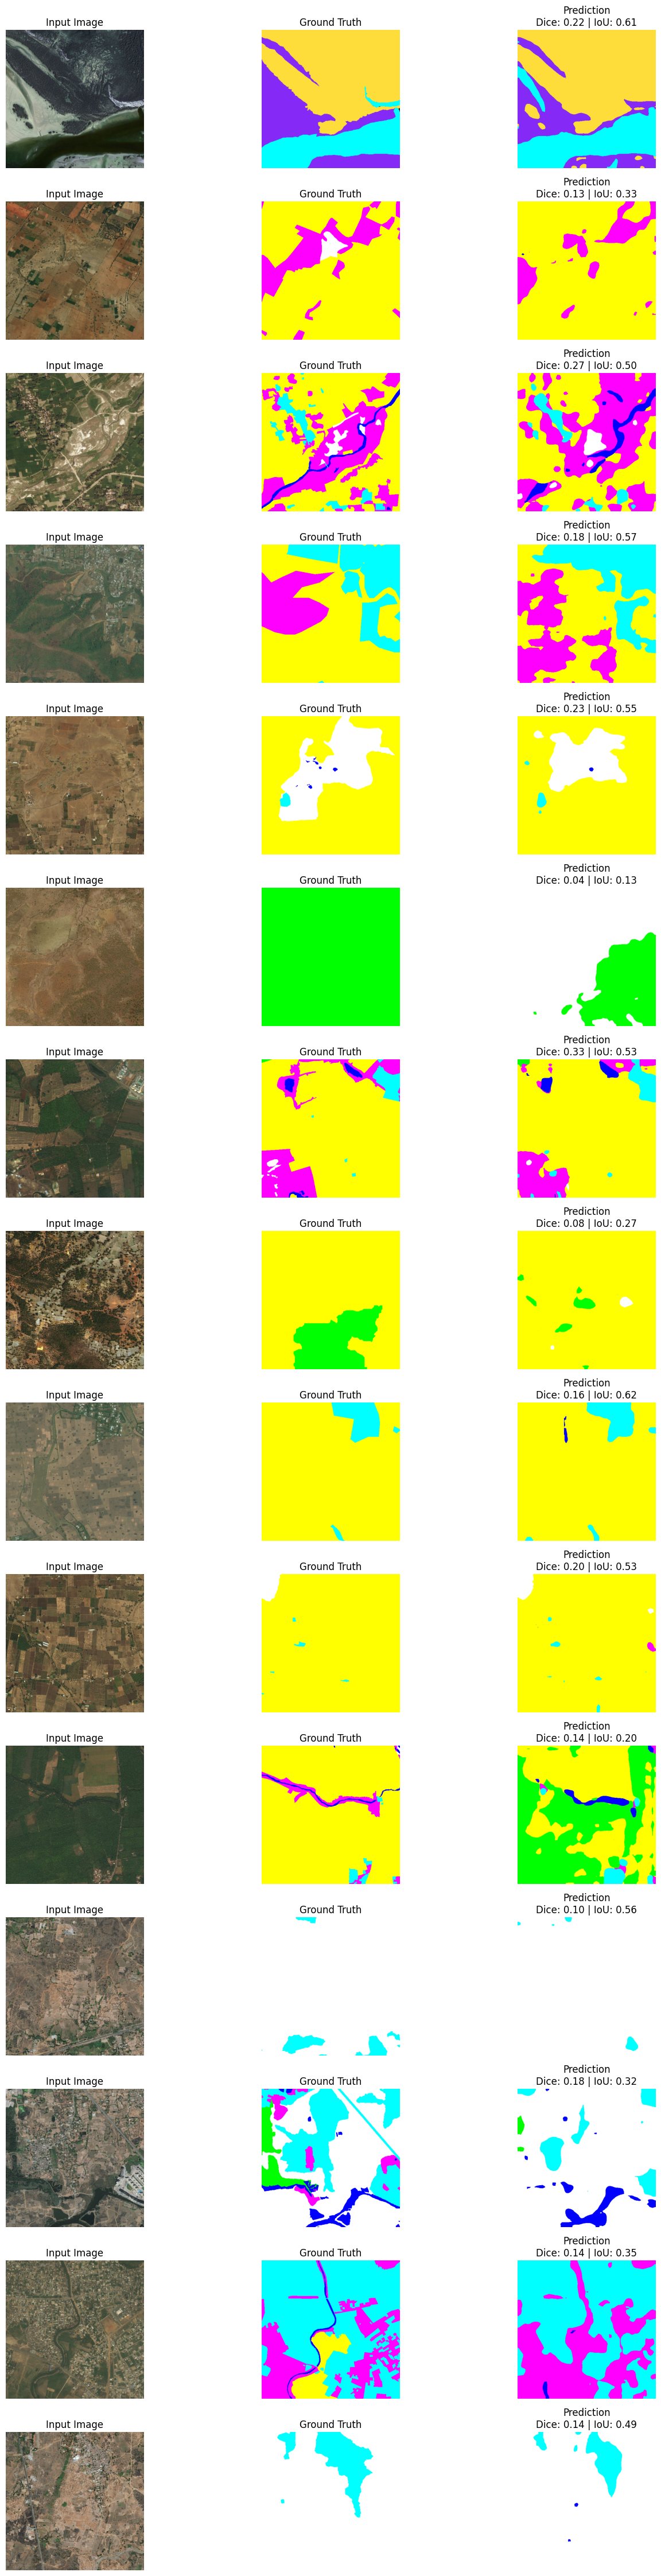

In [11]:
def calculate_iou_and_dice(pred, target, num_classes=NUM_CLASSES):
    ious = []
    dices = []
    for cls in range(num_classes):
        pred_cls = (pred == cls)
        target_cls = (target == cls)
        intersection = np.logical_and(pred_cls, target_cls).sum()
        union = np.logical_or(pred_cls, target_cls).sum()
        if union == 0:
            iou = float('nan')
        else:
            iou = intersection / union
        dice = (2 * intersection) / (pred_cls.sum() + target_cls.sum() + 1e-6)
        ious.append(iou)
        dices.append(dice)
    return np.nanmean(ious), np.nanmean(dices)

def class_mask_to_rgb(mask):
    rgb = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for class_id, rgb_val in class_to_rgb.items():
        rgb[mask == class_id] = rgb_val
    return rgb

def visualize_predictions(model, dataset, num_samples):
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)

    plt.figure(figsize=(15, num_samples * 3))

    for i, idx in enumerate(indices):
        img, gt_mask = dataset[idx]
        img_input = img.unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            output = model(img_input)
            if isinstance(output, dict):  # DeeplabV3 returns a dict
                output = output["out"]
            output = torch.nn.functional.interpolate(
                output, size=gt_mask.shape, mode='bilinear', align_corners=False
            )
            pred_mask = torch.argmax(output.squeeze(), dim=0).cpu().numpy()


        # Compute metrics
        mean_iou, mean_dice = calculate_iou_and_dice(pred_mask, gt_mask.numpy())

        # Convert to RGB
        rgb_gt = class_mask_to_rgb(gt_mask.numpy())
        rgb_pred = class_mask_to_rgb(pred_mask)
        img_np = img.permute(1, 2, 0).cpu().numpy()
        img_np = (img_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
        img_np = np.clip(img_np * 255, 0, 255).astype(np.uint8)

        # Show row
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(img_np)
        plt.title("Input Image")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(rgb_gt)
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(rgb_pred)
        plt.title(f"Prediction\nDice: {mean_dice:.2f} | IoU: {mean_iou:.2f}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    
# Show predictions
visualize_predictions(model, val_dataset, num_samples=15)